# EDA

In [99]:
%reload_ext autoreload
%autoreload 2

In [100]:
import pandas as pd
import numpy as np
import sys
import os
import toml
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sns


sys.path.append(os.path.abspath('..'))
from utils import model

In [101]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [66]:
def get_survival_rate(data):
    return data['Survived'].mean()

def get_death_rate(data):
    return 1 - get_survival_rate(data)

### Age

Age is missing for 177 / 893 training rows, 86 / 418 test rows. ~30% ageless passengers survived.

Age distribution somewhat multimodal, positive skew, peaking around 22, median around 35

Age alone isn't a good predictor

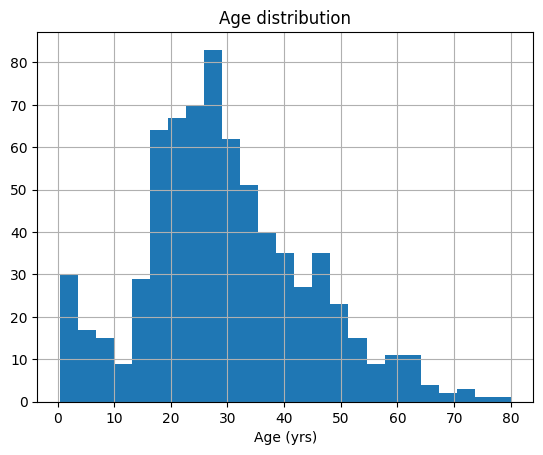

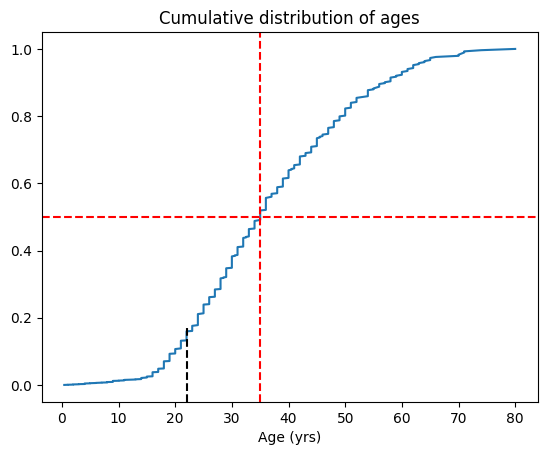

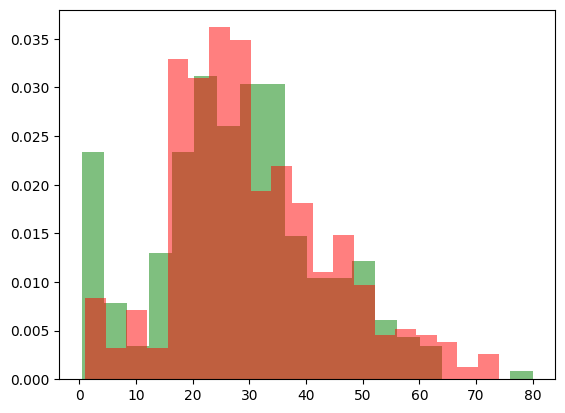

In [67]:
ages = train[~train.Age.isna()].Age
labels = train[~train.Age.isna()].Survived

ages.hist(bins=25)
plt.title('Age distribution')
plt.xlabel('Age (yrs)')
plt.show()

plt.plot(sorted(ages), (np.cumsum(sorted(ages)) / sum(ages)))
plt.title('Cumulative distribution of ages')
plt.xlabel('Age (yrs)')
plt.axhline(0.5, color='r', linestyle='--')
plt.axvline(35, color='r', linestyle='--')
plt.axvline(22, color='k', linestyle='--', ymax=0.2)
plt.show()

plt.hist(ages[labels == 1], bins=20, density=True, alpha=0.5, color='g', label='Survived')
plt.hist(ages[labels == 0], bins=20, density=True, alpha=0.5, color='r', label='Died');

### Sex

Female passengers were more likely to survive.

In [68]:
print(f'Survival rate: {get_survival_rate(train):.2f}')
print("")
print(f'Female survival rate: {get_survival_rate(train[train['Sex'] == 'female']):.2f}')
print(f'Male survival rate: {get_survival_rate(train[train.Sex == 'male']):.2f}')
print("")

male_count = train[train['Sex'] == 'male'].shape[0]
female_count = train[train['Sex'] == 'female'].shape[0]
ratio = male_count / female_count
print(f'Male to Female ratio: {ratio:.2f}')

Survival rate: 0.38

Female survival rate: 0.74
Male survival rate: 0.19

Male to Female ratio: 1.84


In [7]:
sex_model = model.SexBaselineModel()
sex_model.evaluate(train, train['Survived'])

np.float64(0.7867564534231201)

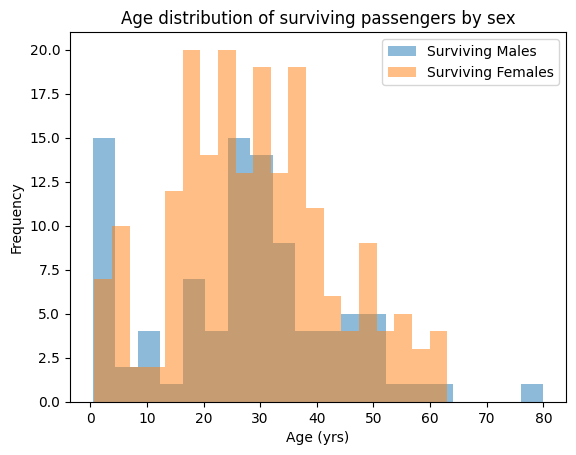

In [8]:
surviving_males = train[(train['Sex'] == 'male') & (train['Survived'] == 1)]['Age'].dropna()
surviving_females = train[(train['Sex'] == 'female') & (train['Survived'] == 1)]['Age'].dropna()

plt.hist(surviving_males, bins=20, alpha=0.5, label='Surviving Males')
plt.hist(surviving_females, bins=20, alpha=0.5, label='Surviving Females')
plt.title('Age distribution of surviving passengers by sex')
plt.xlabel('Age (yrs)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Were single men less likely to survive? A little bit.

Perhaps familial groups and women & children were given priority in lifeboats.

In [9]:
print(get_death_rate(train[(train.Sex == 'male') & ((train.Parch > 0) | (train.SibSp > 0))]))
print(get_death_rate(train[(train.Sex == 'male') & ((train.Parch == 0) & (train.SibSp == 0))]))

0.7289156626506024
0.8442822384428224


### Numbers of siblings/spouses

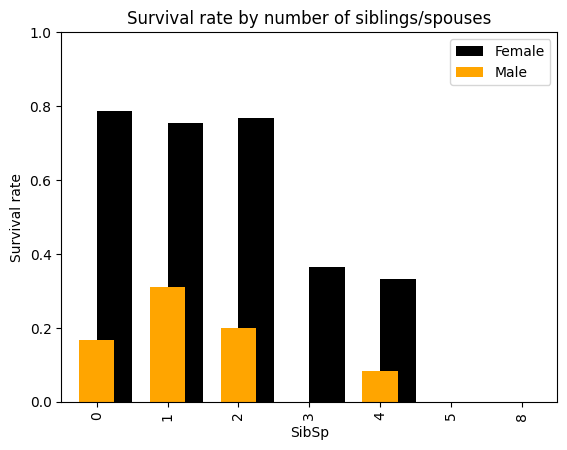

In [10]:
train[train.Sex == 'female'].groupby('SibSp')['Survived'].mean().plot(kind='bar', color='k', align='edge', label='Female')
plt.title('Survival rate by number of siblings/spouses')
plt.ylabel('Survival rate')
plt.ylim(0, 1)

train[train.Sex == 'male'].groupby('SibSp')['Survived'].mean().plot(kind='bar', color='orange', align='center', label='Male')
plt.legend()

### Names and tickets For familial relationships

In [11]:
NAME_REGEX = r'(?P<last_name>[A-Za-z]+), (?P<title>[A-Za-z]+)\. (?P<first_name>[A-Za-z]+)'

def parse_names(df):
    df['last_name'], df['title'], df['first_name'] = zip(*df['Name'].str.extract(NAME_REGEX).values)
    return df

train = parse_names(train)

In [12]:
tickets_in_train = set(train.Ticket.to_list())
tickets_in_test = set(test.Ticket.to_list())
tickets_also_in_test = set(train.Ticket.to_list()).intersection(set(test.Ticket.to_list()))

print(f'Tickets in train: {len(tickets_in_train)}')
print(f'Tickets in test: {len(tickets_in_test)}')
print(f'Tickets in both: {len(tickets_also_in_test)}')

pickle.dump(tickets_also_in_test, open('../data/tickets_in_train_and_test.pkl', 'wb'))
pickle.dump(tickets_in_train, open('../data/tickets_in_train.pkl', 'wb'))

Tickets in train: 681
Tickets in test: 363
Tickets in both: 115


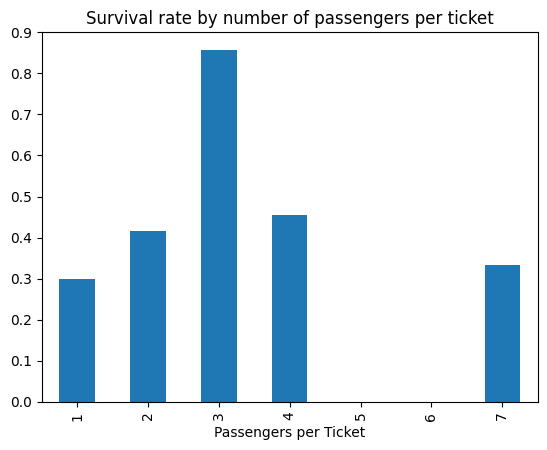

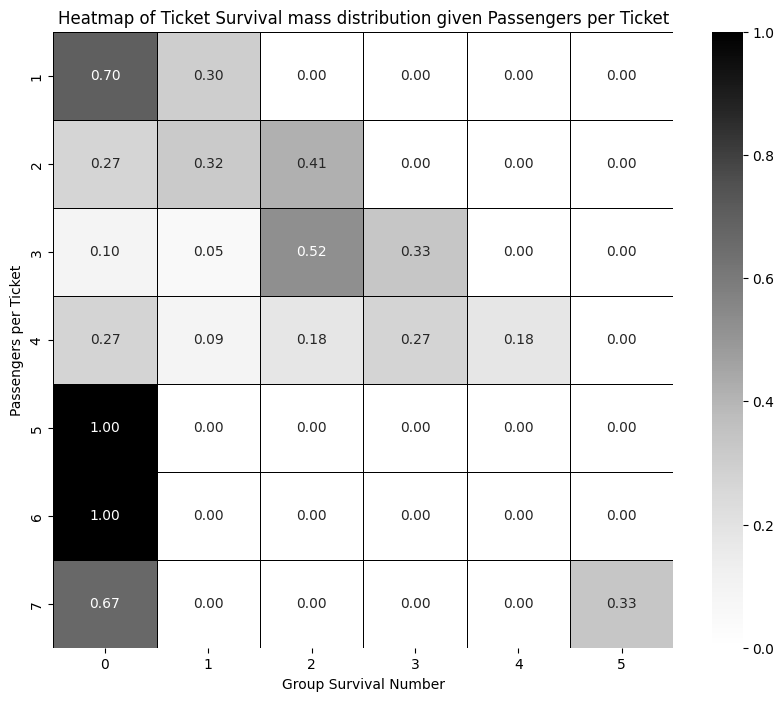

In [157]:


train[train.Ticket.isin(tickets_in_train)].groupby('Ticket').agg({'Survived': lambda x: x.mean() > 0.5, 'PassengerId': 'count'}).rename(columns={'PassengerId': 'Passengers per Ticket'}).groupby('Passengers per Ticket')['Survived'].mean().plot(kind='bar')
plt.title('Survival rate by number of passengers per ticket')
plt.show()

ticket_survival_distribution = train[train.Ticket.isin(tickets_in_train)].groupby('Ticket').agg({'Survived': 'sum', 'PassengerId': 'count'}).rename(columns={'PassengerId': 'Passengers per Ticket', 'Survived': 'Group Survival Number'}).groupby(['Passengers per Ticket', 'Group Survival Number']).size().unstack().fillna(0).astype(int)
ticket_survival_distribution = ticket_survival_distribution.apply(lambda x: x/sum(x), axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(ticket_survival_distribution, cmap='Greys', cbar=True, annot=True, linewidths=.5, linecolor='black', fmt='.2f')
plt.title('Heatmap of Ticket Survival mass distribution given Passengers per Ticket')
plt.xlabel('Group Survival Number')
plt.ylabel('Passengers per Ticket')
plt.show()

ticket_survival_distribution.to_csv('../data/ticket_survival_rates.csv')

It may make sense to consider the relative probabilities of survival of k+x in n+1 members among x = 0,1,2,3 and choose the most likely x=x_max. Then, x_max passengers in the test set for that ticket will survive.

In [162]:
def load_training_data_ticket() -> pd.DataFrame:
    '''Load the training data and compute the number of people on the associated ticket
    
    return: pd.DataFrame grouped by ticket with the current number of training data survivors and training passengers
    
    '''
    train = pd.read_csv('../data/train.csv')
    with open('../data/tickets_in_train_and_test.pkl', 'rb') as f:
        tickets_in_both = pickle.load(f)
    return train[train.Ticket.isin(tickets_in_both)].groupby('Ticket').agg(
        {'Survived': 'sum',
         'PassengerId': 'count'}).rename(
             columns={'PassengerId': 'TrainingTicketSize', 'Survived': 'TrainingSurvived'}
             )

def generate_ticket_statistics(row):
    m = row['TestTicketSize'] # Int, at least 1
    n = int(row['TrainingTicketSize'] + m) # Int, at least m
    # Return NaN if n > 7, as we have no training data for this case
    if n > 7:
        return np.nan, n
    k = int(row['TrainingSurvived']) # Int, at least 0

    M = ticket_survival_distribution.loc[n, k:k+m+1].values
    p = 1 - (M[0]/M.sum())
    return p, n

In [175]:
ticket_model = model.TicketUponLifeboatModel()
ticket_model.evaluate(train, train['Survived'])

np.float64(0.6644219977553311)

Seemingly not as strong a predictor as gender